# Laboratorio 4 BI

### Integrantes:
### Luisa Fernanda Fuentes Ladino - 202014321
### Andrés Felipe Lugo Saavedra - 202012538

In [27]:
seed = 161
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Composicion de pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler

# Regresion lineal
from sklearn.linear_model import LinearRegression

# Importar/ Exportar modelos
from joblib import dump, load

# Metricas
from sklearn.metrics import mean_squared_error as mse

# q-q plots
import scipy.stats as stats

# Carga de datos

In [28]:
# Se cargan los datos. 
df_original = pd.read_csv('202220_Laboratorio_3_data_university_admission_train.csv')
df_train = df_original.copy()
print(df_train.shape)
df_train.head(5)

(1569, 10)


,Unnamed: 0,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Admission Points
0,0,479,327,113,4,4.00,2.77,8.88,1,84.47
1,1,446,301,92,1,1.85,1.50,7.71,0,45.08
2,2,336,297,100,1,2.41,1.59,7.89,0,47.42
3,3,20,303,98,3,3.50,3.00,8.50,0,62.00
4,4,432,320,94,2,1.38,3.50,8.78,1,73.00


In [29]:
df_test = pd.read_csv('202220_Laboratorio_3_data_university_admission_test.csv')
print(df_test.shape)
df_test.head(5)

(175, 8)


,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
0,117,299,102,3,4.0,3.5,8.62,0
1,49,321,110,3,3.5,5.0,8.85,1
2,94,301,97,2,3.0,3.0,7.88,1
3,108,338,117,4,3.5,4.5,9.46,1
4,327,299,100,3,2.0,2.0,8.02,0


# Entendimiento y perfilamiento de datos

In [30]:
df_train.dtypes

Unnamed: 0             int64
Serial No.             int64
GRE Score              int64
TOEFL Score            int64
University Rating      int64
SOP                  float64
LOR                  float64
CGPA                 float64
Research               int64
Admission Points     float64
dtype: object

In [31]:
df_test.dtypes

Serial No.             int64
GRE Score              int64
TOEFL Score            int64
University Rating      int64
SOP                  float64
LOR                  float64
CGPA                 float64
Research               int64
dtype: object

Saber si hay valores nuelos en las columnas

In [32]:
df_train.isnull().sum()

Unnamed: 0            0
Serial No.            0
GRE Score             0
TOEFL Score           0
University Rating     0
SOP                   0
LOR                   0
CGPA                  0
Research              0
Admission Points     65
dtype: int64

In [33]:
df_test.isnull().sum()

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
dtype: int64

## Limpieza de datos, se eliminarán los valores nulos, los duplicados y las columnas que no aportan información valiosa a la regresión (Serial No y Unnamed)

In [34]:
df_train_l=df_train.copy()

df_train_l = df_train_l.dropna()
df_train_l = df_train_l.drop_duplicates()

df_train_l = df_train_l.drop(['Unnamed: 0', 'Serial No.'], axis=1)

df_train_l.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Admission Points
0,327,113,4,4.00,2.77,8.88,1,84.47
1,301,92,1,1.85,1.50,7.71,0,45.08
2,297,100,1,2.41,1.59,7.89,0,47.42
3,303,98,3,3.50,3.00,8.50,0,62.00
4,320,94,2,1.38,3.50,8.78,1,73.00


In [35]:
df_train_l.isnull().sum()

GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Admission Points     0
dtype: int64

#### Búsqueda de relaciones entre variables (diagramas de dispersión), todo esto con nuestra variable objetivo (Admission Points)

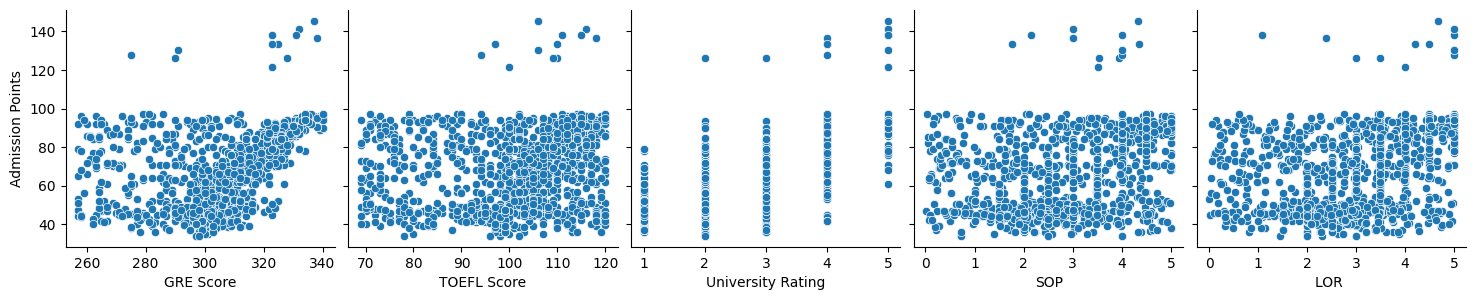

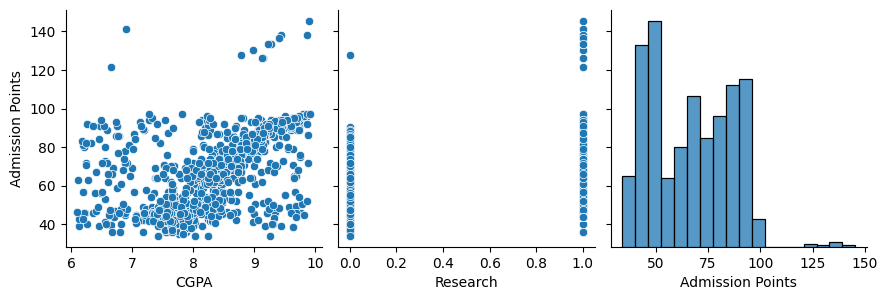

In [36]:
sns.pairplot(df_train_l, height=3, y_vars = 'Admission Points', x_vars = df_train_l.columns[0:5], kind='scatter')
sns.pairplot(df_train_l, height=3, y_vars = 'Admission Points', x_vars = df_train_l.columns[5:], kind='scatter')

Podemos observar que unos buenos candidatos muy relacionados con la varibale objetivo son:
1. CGPA
2. GRE Score

#### Búsqueda de relaciones entre variables (Matriz de correlaciones)

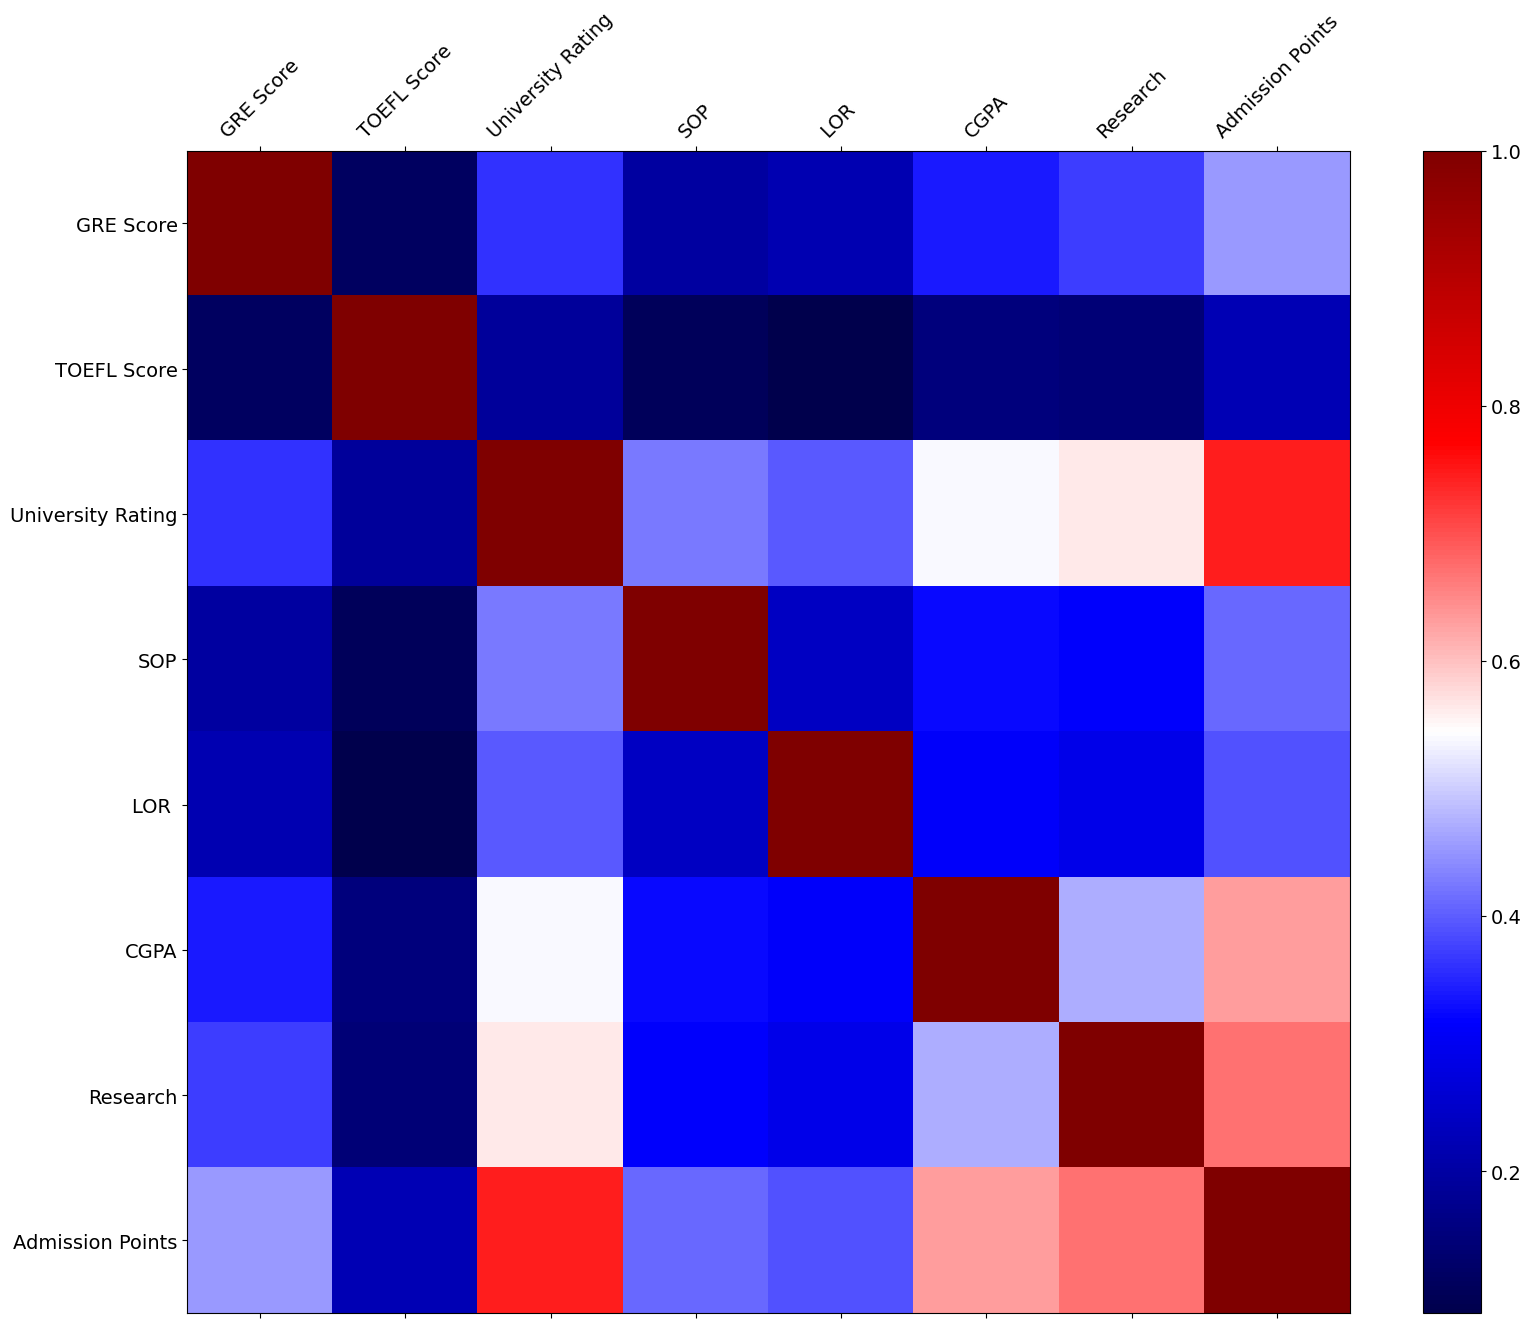

In [37]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df_train_l.corr(), fignum=f.number, cmap = 'seismic')
plt.xticks(range(df_train_l.select_dtypes(['number']).shape[1]), df_train_l.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df_train_l.select_dtypes(['number']).shape[1]), df_train_l.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
_ = cb.ax.tick_params(labelsize=14)

Podemos observar que unos buenos candidatos muy relacionados con la varibale objetivo son:
1. CGPA
2. University Rating
3. Research

# Implementación de la Regresión Lineal

In [38]:
# Se usa un transformador para seleccionar unicamente las columnas que se quieren usar
selected_cols = ['CGPA','University Rating','Research']

pre = [('initial',ColumnTransformer([("selector", 'passthrough',selected_cols)])),]

In [39]:
# Creación del modelo
model = [('model', LinearRegression())]

In [40]:
# Decalra el pipeline
pipeline = Pipeline(pre+model)

In [41]:
# Extraemos las variables explicativas y objetivo para entrenar
X = df_train_l.drop('Admission Points', axis = 1)
y = df_train_l['Admission Points']

pipeline = pipeline.fit(X,y)

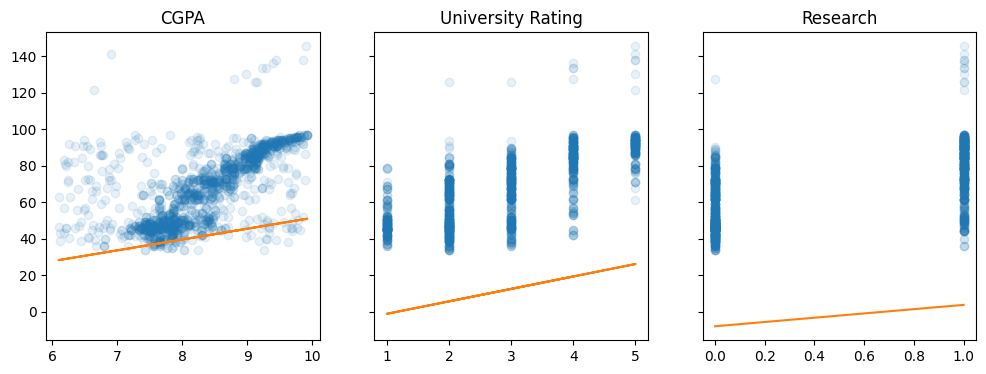

In [42]:
# Visualizamos la regresion lineal en cada dimension
f, axs = plt.subplots(1, len(selected_cols), sharey=True, figsize = (12,4))

for i in range(len(selected_cols)):

    pos_col = i
    col = selected_cols[pos_col]

    # Variable x
    x = X[col]
    # Pendiente
    m = pipeline['model'].coef_[pos_col]
    # Interceto
    b = pipeline['model'].intercept_

    axs[i].plot(x, y, 'o', alpha = 0.1)
    axs[i].plot(x, x*m + b)
    axs[i].set_title(col)

# Exportar e Importar el Modelo

In [43]:
# Usamos la lbreria joblib
filename = 'modelo.joblib'
# Se guarda
dump(pipeline, filename) 
# Se lee
p2 = load(filename)
p2

Pipeline(steps=[('initial',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['CGPA', 'University Rating',
                                                   'Research'])])),
                ('model', LinearRegression())])

In [44]:
df_test_c=df_test.copy()
df_test_c.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
0,117,299,102,3,4.0,3.5,8.62,0
1,49,321,110,3,3.5,5.0,8.85,1
2,94,301,97,2,3.0,3.0,7.88,1
3,108,338,117,4,3.5,4.5,9.46,1
4,327,299,100,3,2.0,2.0,8.02,0


In [45]:
# Clasificamos los datos de test
df_test_c['Admission Points'] = p2.predict(df_test_c)

# Métricas

In [46]:
p2.score(X,y)

0.690088535136133

In [47]:
y_true = y
y_predicted = p2.predict(X)
np.sqrt(mse(y_true, y_predicted))

10.714538444585036

<AxesSubplot:xlabel='Admission Points', ylabel='Count'>

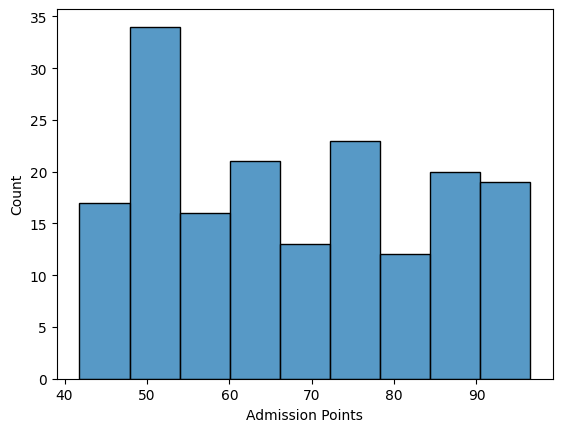

In [48]:
sns.histplot(df_test_c['Admission Points'])

In [49]:
df_test_c.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Admission Points
0,117,299,102,3,4.0,3.5,8.62,0,63.723027
1,49,321,110,3,3.5,5.0,8.85,1,76.826433
2,94,301,97,2,3.0,3.0,7.88,1,64.233983
3,108,338,117,4,3.5,4.5,9.46,1,87.278908
4,327,299,100,3,2.0,2.0,8.02,0,60.156403


# Coeficientes

In [50]:
pipeline['model'].coef_

array([ 5.94437346,  6.82640742, 11.73619957])

In [51]:
# En DataFrame
pd.DataFrame({'columns':selected_cols, 'coef':pipeline['model'].coef_})

,columns,coef
0,CGPA,5.944373
1,University Rating,6.826407
2,Research,11.736200
